In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

Data Loaded: 245305 rows (15-min intervals)
Training Data: (195706, 6)
Testing Data: (48927, 6)

Training XGBoost Model... (Thoda waqt lagega)
[0]	validation_0-rmse:45.15841	validation_1-rmse:48.10060
[100]	validation_0-rmse:7.65891	validation_1-rmse:8.31650
[127]	validation_0-rmse:7.43284	validation_1-rmse:8.70625
------------------------------
XGBoost RESULTS (15-Min):
MAE: 5.0397
RMSE: 8.1049
------------------------------


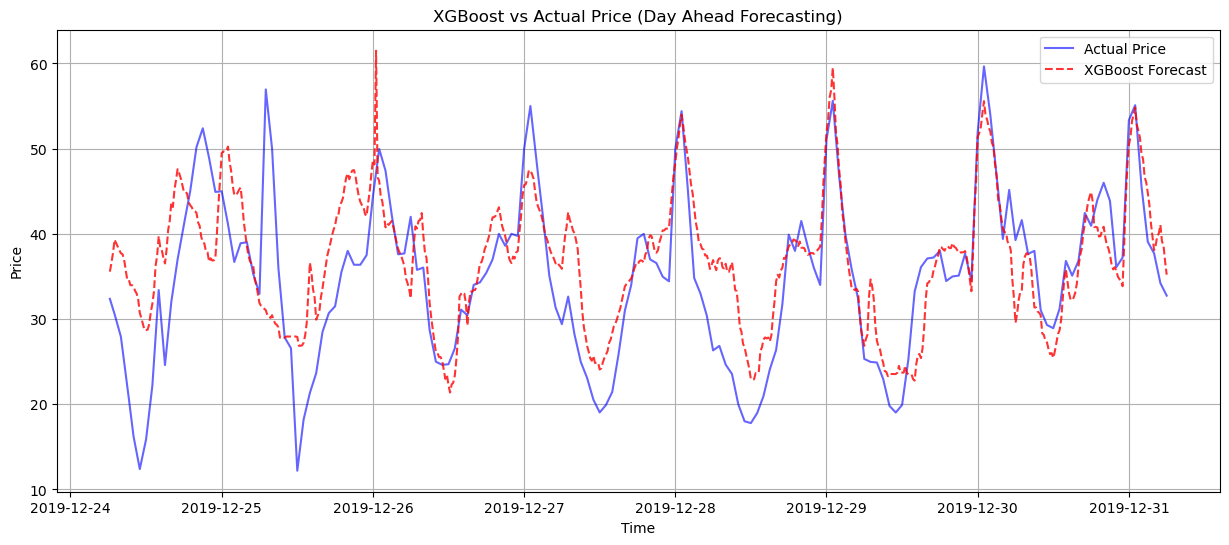

<Figure size 1000x400 with 0 Axes>

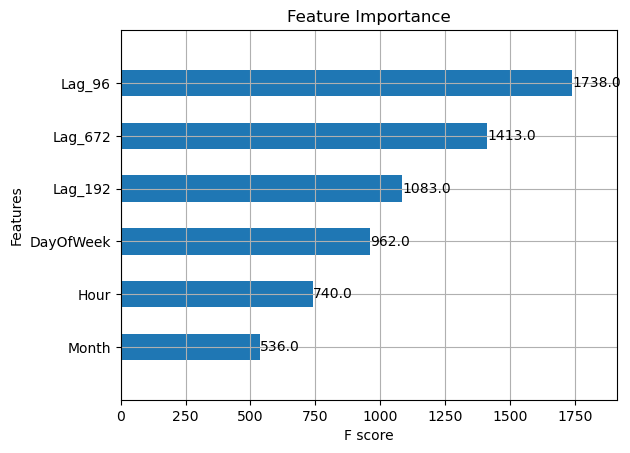

In [ ]:
# Univariant
# !pip install xgboost

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. LOAD & PREPARE DATA ---
file_name = '../data/refixed_price_only_timeseries.csv'
try:
    df = pd.read_csv(file_name)
    # Column fix logic
    col_name = 'GBP/mWh' if 'GBP/mWh' in df.columns else df.columns[-1]
    df = df[[col_name]].rename(columns={col_name: 'Price'})
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df.dropna(inplace=True)
    
    # Dates & 15-Min Resampling
    df['Date'] = pd.date_range(start='2013-01-01', periods=len(df), freq='h')
    df.set_index('Date', inplace=True)
    df = df.resample('15min').interpolate(method='linear')
    print(f"Data Loaded: {len(df)} rows (15-min intervals)")

except Exception as e:
    print(f"Error loading file: {e}")

# --- 2. FEATURE ENGINEERING (XGBoost ke liye inputs) ---
# Hum model ko batayenge k time kya hai aur purani history kya thi

df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek  # 0=Monday, 6=Sunday
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter

# Lag Features (Previous history)
# Target: Day-Ahead (24 hours = 96 steps)
df['Lag_96'] = df['Price'].shift(96)  # Exactly 24 hours ago
df['Lag_192'] = df['Price'].shift(192) # 48 hours ago (2 Days ago)
df['Lag_672'] = df['Price'].shift(672) # 1 Week ago (Same time last week)

# Drop NaN values created by shifting
df.dropna(inplace=True)

# --- 3. TRAIN / TEST SPLIT ---

train_size = int(len(df) * 0.8) # 80% Training, 20% Testing
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

# Features and targets are separated
features = ['Hour', 'DayOfWeek', 'Month', 'Lag_96', 'Lag_192', 'Lag_672']
target = 'Price'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

print(f"Training Data: {X_train.shape}")
print(f"Testing Data: {X_test.shape}")

# --- 4. TRAIN XGBOOST MODEL ---
print("\nTraining XGBoost Model... (Thoda waqt lagega)")
model = xgb.XGBRegressor(
    n_estimators=1000,    
    learning_rate=0.05,   
    early_stopping_rounds=50, 
    n_jobs=-1             
)

# Training Started
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100  # Har 100 steps par progress dikhay
)

# --- 5. PREDICTION & RESULTS ---
test['Prediction'] = model.predict(X_test)

mae = mean_absolute_error(test['Price'], test['Prediction'])
rmse = np.sqrt(mean_squared_error(test['Price'], test['Prediction']))

print("-" * 30)
print(f"XGBoost RESULTS (15-Min):")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print("-" * 30)

# --- 6. PLOTTING ---
# Last 1 week ka comparison
plt.figure(figsize=(15, 6))
subset = test.tail(96 * 7) # Last 7 days

plt.plot(subset.index, subset['Price'], label='Actual Price', color='blue', alpha=0.6)
plt.plot(subset.index, subset['Prediction'], label='XGBoost Forecast', color='red', linestyle='--', alpha=0.8)

plt.title('XGBoost vs Actual Price (Day Ahead Forecasting)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance Plot
plt.figure(figsize=(10, 4))
xgb.plot_importance(model, max_num_features=10, height=0.5)
plt.title("Feature Importance")
plt.show()

Data Loaded Successfully: 61327 rows (Hourly Frequency)

Training XGBoost on 48927 hourly samples...
[0]	validation_0-rmse:45.50270	validation_1-rmse:48.17432
[100]	validation_0-rmse:8.09856	validation_1-rmse:8.62166
[139]	validation_0-rmse:7.66812	validation_1-rmse:9.28997
----------------------------------------
XGBoost RESULTS (HOURLY DATA):
MAE  : 5.1993
RMSE : 8.1972
----------------------------------------


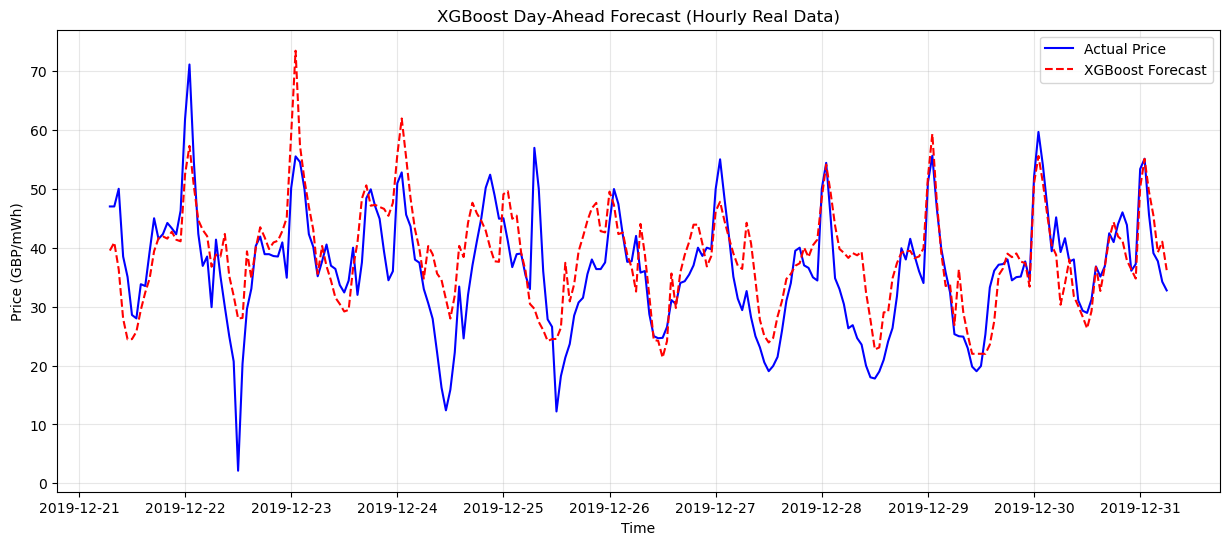

<Figure size 1000x500 with 0 Axes>

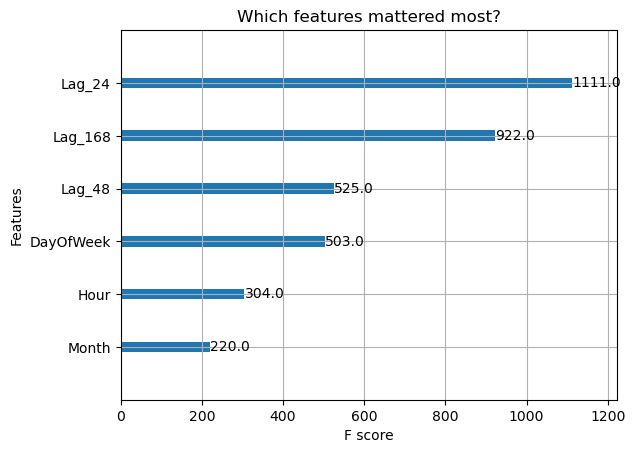

In [ ]:
# --- INSTALL LIBRARY (If needed) ---
# !pip install xgboost

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. LOAD ORIGINAL DATA ---
file_name = '../data/refixed_price_only_timeseries.csv'

try:
    df = pd.read_csv(file_name)
    
    # Fix Column Name (Find 'GBP/mWh')
    col_name = 'GBP/mWh' if 'GBP/mWh' in df.columns else df.columns[-1]
    df = df[[col_name]].rename(columns={col_name: 'Price'})
    
    # Convert to Numeric and clean
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df.dropna(inplace=True)
    
    # Set Hourly Index (Original Resolution)
    df['Date'] = pd.date_range(start='2013-01-01', periods=len(df), freq='h')
    df.set_index('Date', inplace=True)
    
    print(f"Data Loaded Successfully: {len(df)} rows (Hourly Frequency)")

except Exception as e:
    print(f"Error: {e}")

# --- 2. FEATURE ENGINEERING (HOURLY) ---
# Creating features so the model can learn patterns

# Time Features
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month

# Lag Features (The most important part for Time Series)
# Target: Day-Ahead Forecast
df['Lag_24'] = df['Price'].shift(24)   # Same time yesterday
df['Lag_48'] = df['Price'].shift(48)   # Same time 2 days ago
df['Lag_168'] = df['Price'].shift(168) # Same time last week (Weekly Seasonality)

# Remove rows with NaN (empty) values created by shifting
df.dropna(inplace=True)

# --- 3. TRAIN / TEST SPLIT ---
# Using 80% data for training, 20% for testing
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

# Define Input (X) and Output (y)
features = ['Hour', 'DayOfWeek', 'Month', 'Lag_24', 'Lag_48', 'Lag_168']
target = 'Price'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# --- 4. TRAIN XGBOOST MODEL ---
print(f"\nTraining XGBoost on {len(X_train)} hourly samples...")

model = xgb.XGBRegressor(
    n_estimators=1000,     # Number of trees
    learning_rate=0.05,    # Step size
    max_depth=5,           # Tree depth (prevents overfitting)
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

# --- 5. EVALUATION ---
# Making predictions on the Test Set
test['Prediction'] = model.predict(X_test)

mae = mean_absolute_error(test['Price'], test['Prediction'])
rmse = np.sqrt(mean_squared_error(test['Price'], test['Prediction']))

print("-" * 40)
print(f"XGBoost RESULTS (HOURLY DATA):")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print("-" * 40)

# --- 6. PLOTTING ---
# Plotting last 10 days (240 hours) for clear view
plt.figure(figsize=(15, 6))
subset = test.tail(240)

plt.plot(subset.index, subset['Price'], label='Actual Price', color='blue', linewidth=1.5)
plt.plot(subset.index, subset['Prediction'], label='XGBoost Forecast', color='red', linestyle='--', linewidth=1.5)

plt.title('XGBoost Day-Ahead Forecast (Hourly Real Data)')
plt.xlabel('Time')
plt.ylabel('Price (GBP/mWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Feature Importance
plt.figure(figsize=(10, 5))
xgb.plot_importance(model, max_num_features=10)
plt.title("Which features mattered most?")
plt.show()

Loading Data...
Data Ready: 61327 Hourly Records loaded.

Training XGBoost Model on 51985 samples...
[0]	validation_0-rmse:17.67554	validation_1-rmse:12.57214
[100]	validation_0-rmse:7.89275	validation_1-rmse:7.25257
[122]	validation_0-rmse:7.64811	validation_1-rmse:7.25964
----------------------------------------
XGBoost RESULTS (Hourly Real Data):
MAE  : 4.7836
RMSE : 7.2379
----------------------------------------


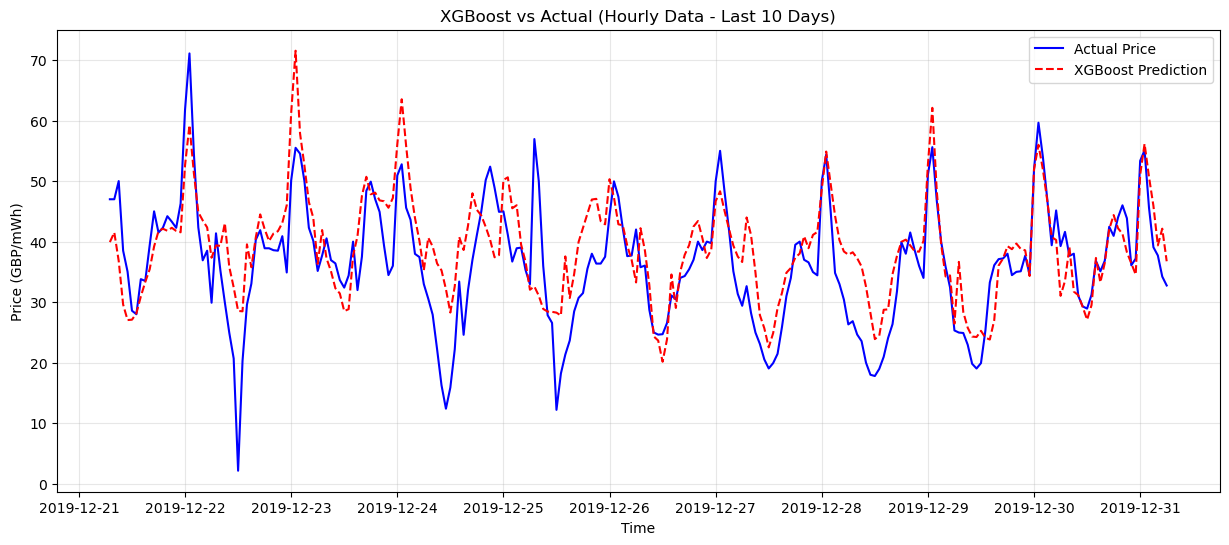

<Figure size 1000x500 with 0 Axes>

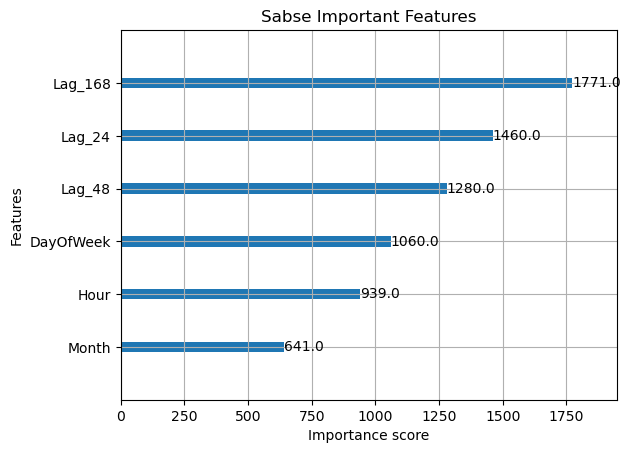

In [ ]:
# --- 1. IMPORTS & SETUP ---
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 2. LOAD REAL DATA (Hourly) ---
file_name = '../data/refixed_price_only_timeseries.csv'
print("Loading Data...")

try:
    df = pd.read_csv(file_name)
    
    # Column Selection (Safety Check)
    if 'GBP/mWh' in df.columns:
        df = df[['GBP/mWh']].rename(columns={'GBP/mWh': 'Price'})
    else:
        df = df.iloc[:, -1:].rename(columns={df.columns[-1]: 'Price'})

    # Clean Data (Numeric banao)
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df.dropna(inplace=True)

    # Set Hourly Index
    df['Date'] = pd.date_range(start='2013-01-01', periods=len(df), freq='h')
    df.set_index('Date', inplace=True)
    
    print(f"Data Ready: {len(df)} Hourly Records loaded.")

except Exception as e:
    print(f"Error: {e}")

# --- 3. FEATURE ENGINEERING (Model ko pattern sikhana) ---
# A. Time Features
df['Hour'] = df.index.hour           # Which time of the day
df['DayOfWeek'] = df.index.dayofweek # Weekend 
df['Month'] = df.index.month         # Seasonality like winter or summer
df['Quarter'] = df.index.quarter

# B. Lag Features 
df['Lag_24'] = df['Price'].shift(24)    # Yesterday price at same time
df['Lag_48'] = df['Price'].shift(48)    # 2 days before price
df['Lag_168'] = df['Price'].shift(168)  # last week ago price

# Remove empty rows created by lags
df.dropna(inplace=True)

# --- 4. TRAIN / TEST SPLIT ---
train_size = int(len(df) * 0.85)  # 85% Training 15% Testing
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Features
features = ['Hour', 'DayOfWeek', 'Month', 'Quarter', 'Lag_24', 'Lag_48', 'Lag_168']
target = 'Price'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# --- 5. TRAIN XGBOOST MODEL ---
print(f"\nTraining XGBoost Model on {len(X_train)} samples...")

model = xgb.XGBRegressor(
    n_estimators=1000,      # numbers of tree
    learning_rate=0.05,     # Learning speed
    max_depth=6,            # Tree complexity
    early_stopping_rounds=50, # Validation set
    n_jobs=-1,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100  # Har 100 steps par update de
)

# --- 6. PREDICTION & RESULTS ---
test['Prediction'] = model.predict(X_test)

mae = mean_absolute_error(test['Price'], test['Prediction'])
rmse = np.sqrt(mean_squared_error(test['Price'], test['Prediction']))

print("-" * 40)
print(f"XGBoost RESULTS (Hourly Real Data):")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print("-" * 40)

# --- 7. PLOTTING (Comparison) ---
# Last 10 days (240 hours) ka comparison
plt.figure(figsize=(15, 6))
subset = test.tail(240)

plt.plot(subset.index, subset['Price'], label='Actual Price', color='blue', linewidth=1.5)
plt.plot(subset.index, subset['Prediction'], label='XGBoost Prediction', color='red', linestyle='--', linewidth=1.5)

plt.title('XGBoost vs Actual (Hourly Data - Last 10 Days)')
plt.xlabel('Time')
plt.ylabel('Price (GBP/mWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Feature Importance Plot
plt.figure(figsize=(10, 5))
xgb.plot_importance(model, max_num_features=10)
plt.title("Sabse Important Features")
plt.show()

Loading Multivariate Data...
Data Loaded: 61326 rows. Columns: ['Price', 'temperature', 'coal Price', 'oil Price', 'uranium Price', 'natural gas Price']

Training XGBoost with 10 features...
[0]	validation_0-rmse:46.53302	validation_1-rmse:43.04804
[100]	validation_0-rmse:6.44098	validation_1-rmse:7.11356
[200]	validation_0-rmse:5.63598	validation_1-rmse:7.10043
[210]	validation_0-rmse:5.57378	validation_1-rmse:7.10021
----------------------------------------
MULTIVARIATE XGBOOST RESULTS:
MAE  : 4.6490
RMSE : 7.0697
----------------------------------------


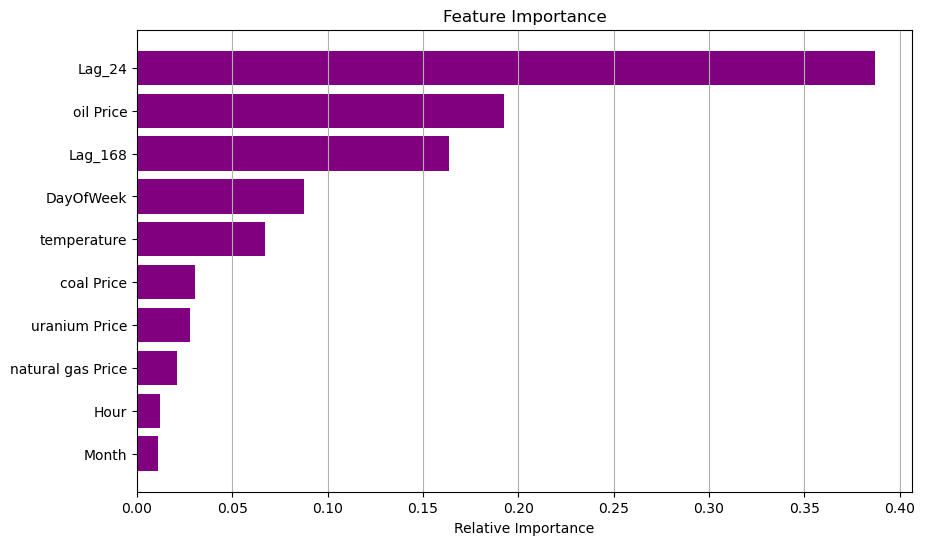

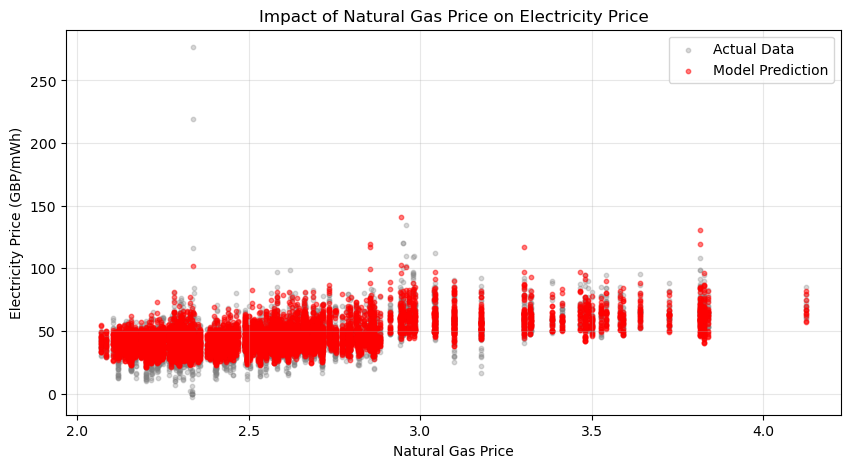

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. LOAD MULTIVARIATE DATA ---
file_name = '../data/re_fixed_multivariate_timeseires.csv'
print("Loading Multivariate Data...")

df = pd.read_csv(file_name)

# Rename Target Column
df.rename(columns={'GBP/mWh': 'Price'}, inplace=True)

# Set Date Index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Sort data just in case
df.sort_index(inplace=True)

print(f"Data Loaded: {len(df)} rows. Columns: {df.columns.tolist()}")

# --- 2. FEATURE ENGINEERING ---
# A. Time Features
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month

# B. Lag Features (History of Price)
df['Lag_24'] = df['Price'].shift(24)    
df['Lag_168'] = df['Price'].shift(168)   


df.dropna(inplace=True)

# --- 3. TRAIN / TEST SPLIT ---
train_size = int(len(df) * 0.85)
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

# Features List
features = ['Hour', 'DayOfWeek', 'Month', 
            'Lag_24', 'Lag_168', 
            'temperature', 'coal Price', 'oil Price', 'uranium Price', 'natural gas Price']

target = 'Price'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# --- 4. TRAIN MODEL ---
print(f"\nTraining XGBoost with {len(features)} features...")

model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

# --- 5. EVALUATION ---
test['Prediction'] = model.predict(X_test)
mae = mean_absolute_error(test['Price'], test['Prediction'])
rmse = np.sqrt(mean_squared_error(test['Price'], test['Prediction']))

print("-" * 40)
print(f"MULTIVARIATE XGBOOST RESULTS:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print("-" * 40)

# --- 6. ANALYSIS: Feature Importance ---
plt.figure(figsize=(10, 6))
# Get feature importance
importance = model.feature_importances_
feat_names = X_train.columns
# Sort them
indices = np.argsort(importance)

plt.title('Feature Importance')
plt.barh(range(len(indices)), importance[indices], color='purple', align='center')
plt.yticks(range(len(indices)), [feat_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid(axis='x')
plt.show()

# --- 7. IMPACT ANALYSIS (Partial Dependence Logic) ---

plt.figure(figsize=(10, 5))
plt.scatter(test['natural gas Price'], test['Price'], alpha=0.3, label='Actual Data', color='gray', s=10)
plt.scatter(test['natural gas Price'], test['Prediction'], alpha=0.5, label='Model Prediction', color='red', s=10)

plt.title('Impact of Natural Gas Price on Electricity Price')
plt.xlabel('Natural Gas Price')
plt.ylabel('Electricity Price (GBP/mWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Loading Data...

--- CORRELATION SCORE (Impact) ---
coal Price           0.349829
natural gas Price    0.130444
oil Price            0.123960
temperature         -0.047870
Name: Price, dtype: float64
------------------------------


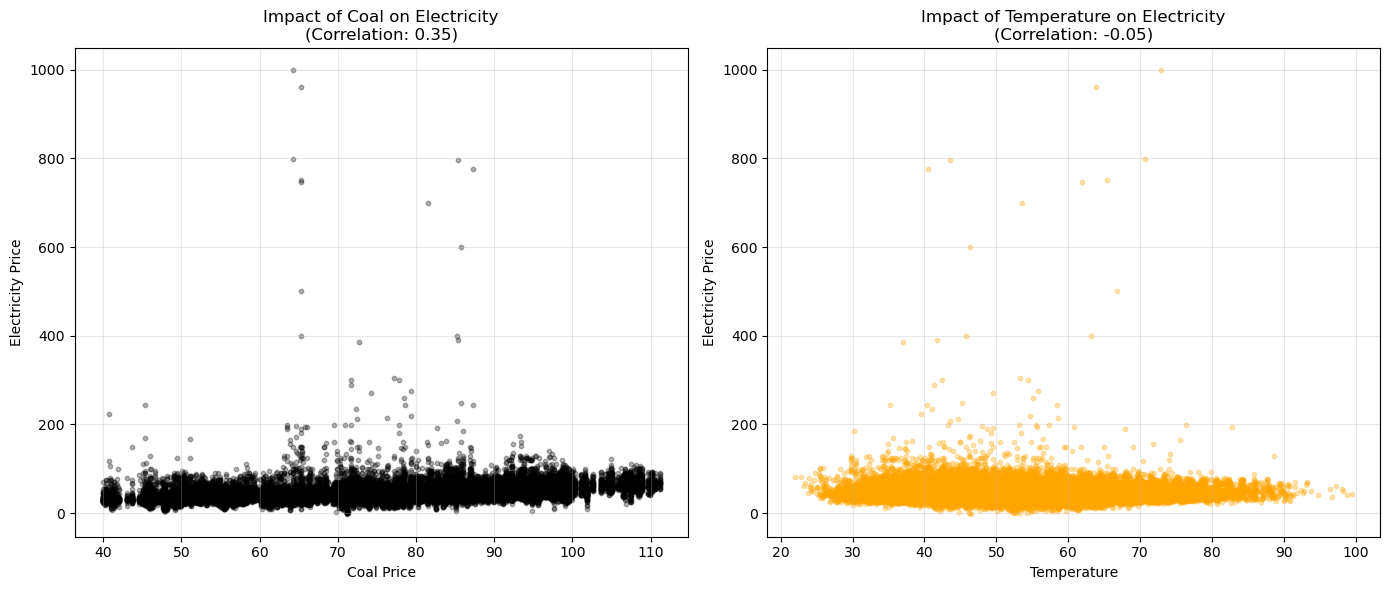

In [ ]:
#Multivariant
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. LOAD DATA ---
file_name = '../data/re_fixed_multivariate_timeseires.csv'
print("Loading Data...")

try:
    df = pd.read_csv(file_name)
    
 
    if 'GBP/mWh' in df.columns:
        df.rename(columns={'GBP/mWh': 'Price'}, inplace=True)
    
    # --- 2. CORRELATION CHECK (Numbers) ---
    features_to_check = ['coal Price', 'temperature', 'oil Price', 'natural gas Price']
    
   
    correlations = df[features_to_check + ['Price']].corr()['Price'].drop('Price').sort_values(ascending=False)
    
    print("\n--- CORRELATION SCORE (Impact) ---")
    print(correlations)
    print("-" * 30)

    # --- 3. PLOTTING (VISUALIZATION) ---
    plt.figure(figsize=(14, 6))

    # GRAPH 1: COAL vs PRICE
    plt.subplot(1, 2, 1)
    # Scatter plot with transparency to see density
    plt.scatter(df['coal Price'], df['Price'], alpha=0.3, color='black', s=10)
    
    # Trend line (Optional decoration)
    plt.title(f"Impact of Coal on Electricity\n(Correlation: {correlations['coal Price']:.2f})")
    plt.xlabel('Coal Price')
    plt.ylabel('Electricity Price')
    plt.grid(True, alpha=0.3)

    # GRAPH 2: TEMPERATURE vs PRICE
    plt.subplot(1, 2, 2)
    plt.scatter(df['temperature'], df['Price'], alpha=0.3, color='orange', s=10)
    
    plt.title(f"Impact of Temperature on Electricity\n(Correlation: {correlations['temperature']:.2f})")
    plt.xlabel('Temperature')
    plt.ylabel('Electricity Price')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")